# Kenya Expanded #

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import numba
import rasterio
import matplotlib.pyplot as plt
import rasterio.mask
import rasterio.plot
import requests

from pathlib import Path
from numba import njit
import seaborn as sns
from scipy.ndimage import distance_transform_edt
from shapely.geometry import box
from affine import Affine
from shapely.geometry import LineString
from shapely.geometry import Point
import affine 

# Kenya Data #

In [2]:
# Bulding Density Data
building_density_path = '/mnt/team/rapidresponse/pub/population/data/03-processed-data/building-layers/KEN/_archive/2020_q2/full.tif'
with rasterio.open(building_density_path) as src:
    # We don't need anything from this dataset except the metadata about 
    # it's shape and resolution.
    meta = src.meta
    kenya_shape = src.shape
    
# Transform Data
transform = meta['transform']
# Out metadata is exactly the same as our in metadata.
out_meta = meta.copy()
target_crs = out_meta['crs']

# Resolution Data
resolution = transform.a  # You can access matrix elements by a,b,c,d,etc, just check you're getting the value you expect.
x_offset = transform.xoff
y_offset = transform.yoff

# Get the width and height in pixels from the metadata
width = meta['width']
height = meta['height']

# Make arrays of [0, 1, ..., width] and [0, 1, ..., height]
x_ind = np.arange(width)  # Just like python's `range` function, but makes a numpy array, which we can do vector math with.
y_ind = np.arange(height) 

# Here is the magic of numpy. We can write the same expressions and they'll
# work pretty much seamlessly across scalars and vectors and higher dimensional arrays
# (as long as the operations are well defined.
x = resolution * (x_ind + 1/2) + x_offset  # Makes an array where each element is now an x-coordinate of a centroid in our CRS
y = -resolution * (y_ind + 1/2) + y_offset

In [3]:
kenya_expanded_shape = (height*3, width*3)

# Calculate the adjustment considering the resolution
adjustment_x = resolution * width  # Width adjustment (to the left)
adjustment_y = resolution * height  # Height adjustment (up)

# Update the transform by adding adjustments
new_transform = Affine(transform.a, transform.b, transform.c - adjustment_x,
                       transform.d, transform.e, transform.f + adjustment_y)



In [4]:
new_transform

Affine(38.21851413728018, 0.0, 2837342.4895579205,
       0.0, -38.21851413728001, 1741541.2522138404)

# Custom Functions #

In [5]:
# I already have a utility function for punching admin size holes out of rasters
def mask_admin(in_path: Path, admin_path: Path, out_path: Path):
    with rasterio.open(in_path) as src:
        admin = gpd.read_file(admin_path).to_crs(src.crs)
        kwargs = {
            'all_touched': True,
            'nodata': np.nan,
        }
        out_image, out_transform = rasterio.mask.mask(
            src, 
            admin.geometry.tolist(),
            **kwargs        
        )
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "nodata": np.nan,
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(out_path, "w", **out_meta) as dest:
        dest.write(out_image)


def rasterize_and_get_indices(gdf, out_shape, transform):
    # Rasterize the GeoDataFrame
    rasterized = rasterio.features.rasterize(
        [(geom, 1) for geom in gdf.geometry],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        all_touched=True,
        dtype=rasterio.uint8
    )

    # Get indices where rasterized data is not empty or 0
    # indices_ones = np.where(rasterized != 0)
    # indices_list = np.array(list(zip(indices_ones[1], indices_ones[0])))
    
    # return rasterized, indices_list
    return rasterized

# Kenya Bounding Box #

In [6]:
# Read in admin0 shapefile
# admin0_path = Path('/mnt/share/homes/mfiking/population/gis/population/kenya_admin_files/ken_admbnda_adm0_iebc_20191031.shp') # Natural Earth Admin0 shapefile

admin0_path = Path('/mnt/team/rapidresponse/pub/population/data/01-raw-data/shapefiles/KEN/Unknown/gadm41_KEN_shp/gadm41_KEN_0.shp')


In [7]:
# Load the admin 0 shapefile for Kenya
kenya_admin0 = gpd.read_file(admin0_path)

In [8]:
kenya_admin0 = kenya_admin0.to_crs(epsg=3857)

# Get the bounding box of Kenya
kenya_bbox = kenya_admin0.geometry.bounds
kenya_bbox

,minx,miny,maxx,maxy
0,3.774798e+06,-526069.87823,4.667205e+06,564140.533673


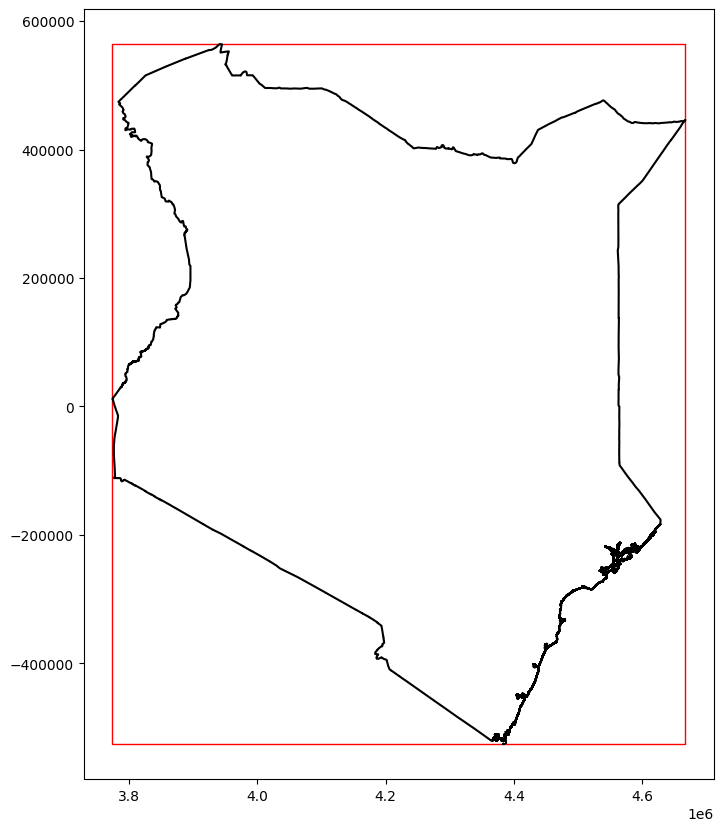

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the envelope
kenya_admin0.envelope.plot(ax=ax, facecolor='none', edgecolor='red')

# Plot the boundary
kenya_admin0.boundary.plot(ax=ax, color='black')

plt.show()


# Use admin0 shapefile to set bounding box and extent #

In [10]:
kenya_admin0.total_bounds

array([3774798.06916971, -526069.8782302 , 4667205.03003507,
        564140.53367254])

# Expand Kenya Bounding Box #

In [11]:
# Extract bounding box coordinates as floats using iloc[0]
minx = float(kenya_bbox.minx.iloc[0])
miny = float(kenya_bbox.miny.iloc[0])
maxx = float(kenya_bbox.maxx.iloc[0])
maxy = float(kenya_bbox.maxy.iloc[0])

# Calculate the expansion sizes for height and width
height_expansion = (maxy - miny) 
width_expansion = (maxx - minx)  

# Create the original bounding box
original_bbox = box(minx, miny, maxx, maxy)


# Create a larger bounding box
larger_bbox = box(
    minx - width_expansion,  # Expanding left
    miny - height_expansion,  # Expanding bottom
    maxx + width_expansion,  # Expanding right
    maxy + height_expansion  # Expanding top
)



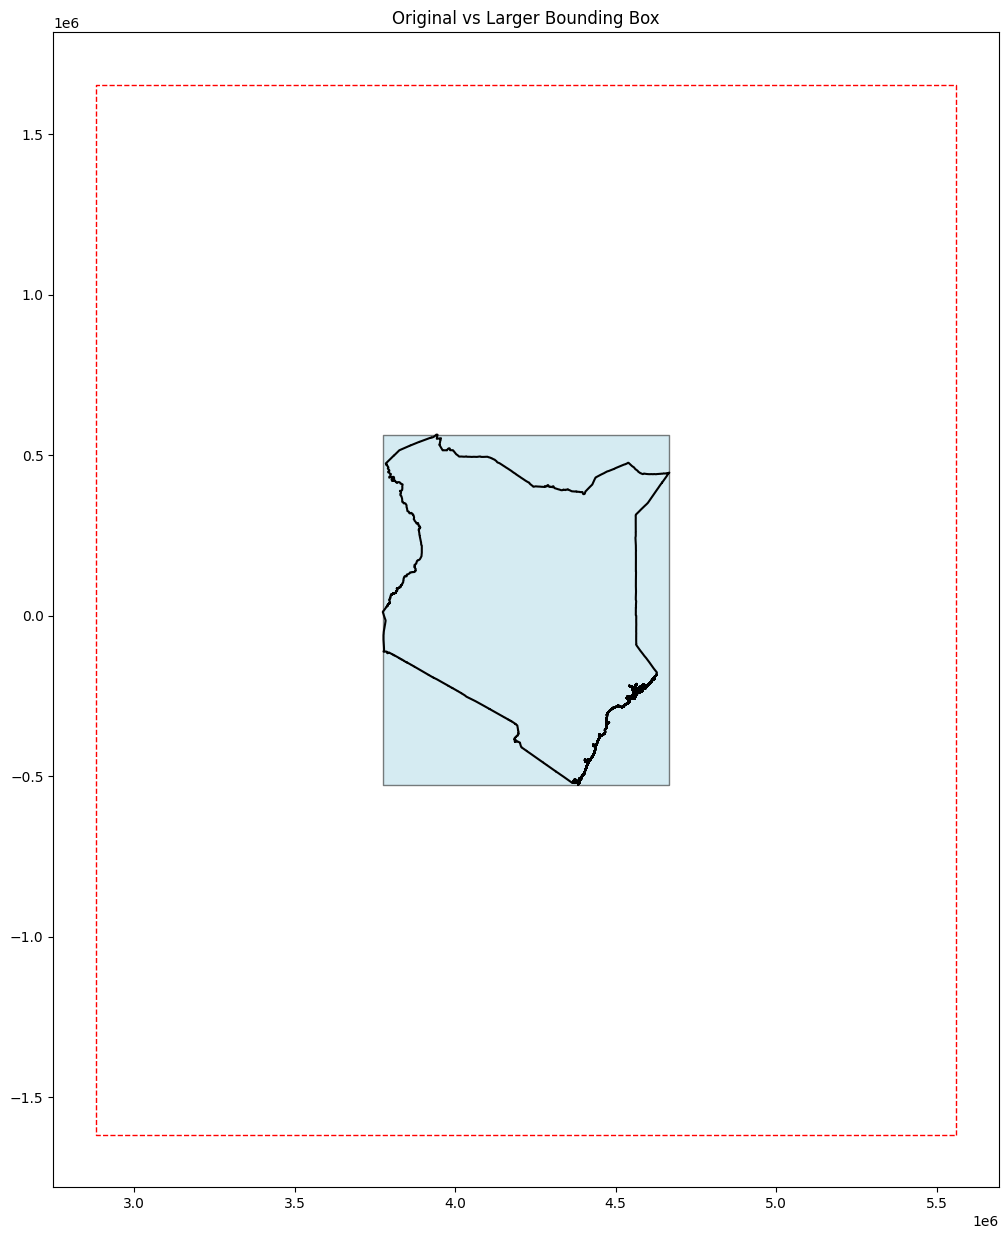

In [12]:
# Convert the bounding boxes to GeoDataFrames for visualization
original_gdf = gpd.GeoDataFrame(geometry=[original_bbox])
larger_gdf = gpd.GeoDataFrame(geometry=[larger_bbox])


# Plotting both bounding boxes
fig, ax = plt.subplots(figsize=(15, 15))
original_gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)
larger_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linestyle='dashed')
kenya_admin0.boundary.plot(ax=ax, color = 'k')
plt.title('Original vs Larger Bounding Box')
plt.show()


# Plot Kenya

In [13]:
# Extract bounding box coordinates as floats using iloc[0] from the larger_bbox
larger_minx = float(larger_bbox.bounds[0])
larger_miny = float(larger_bbox.bounds[1])
larger_maxx = float(larger_bbox.bounds[2])
larger_maxy = float(larger_bbox.bounds[3])

# Read in River Data #

In [ ]:
gdb_file_path = '/mnt/share/homes/mfiking/population/gis/population/test/hydrorivers/HydroRIVERS_v10_af.gdb/HydroRIVERS_v10_af_shp/HydroRIVERS_v10_af_shp/HydroRIVERS_v10_af.shp'
gdf = gpd.read_file(gdb_file_path)

# Subset Vector Data to Kenya #

In [ ]:
# Filter the Africa data using the bounding box of Kenya
kenya_data = gdf.cx[kenya_bbox.iloc[0]['minx']:kenya_bbox.iloc[0]['maxx'],
                              kenya_bbox.iloc[0]['miny']:kenya_bbox.iloc[0]['maxy']]

kenya_data = kenya_data.to_crs(target_crs)

# Modifications #

In [127]:
print('Original Kenya Shape:')
print(kenya_shape)
print('Original transformation:')
print(transform)


Original Kenya Shape:
(29696, 24064)
Original transformation:
| 38.22, 0.00, 3757032.81|
| 0.00,-38.22, 606604.26|
| 0.00, 0.00, 1.00|


In [128]:
print('Expanded Kenya Shape:')
print(kenya_expanded_shape)

Expanded Kenya Shape:
(89088, 72192)


In [129]:
print('Kenya CRS: ', target_crs)
print('Kenya Resolution: ', resolution)

Kenya CRS:  EPSG:3857
Kenya Resolution:  38.21851413728018


In [130]:
print('Width = ', width)
print('Height = ', height)
print('Resolution*Width = ', resolution*width)
print('Resolution*Height = ', resolution*height)
print('Top left Coordinate: ', (transform.c, transform.f))
print('New X coordinate: ', transform.c - resolution*width)
print('New y coordinate: ', transform.f + resolution*height)
print('New top left Coordinate: ', (transform.c - resolution*width, transform.f + resolution*height))

Width =  24064
Height =  29696
Resolution*Width =  919690.3241995103
Resolution*Height =  1134936.9958206723
Top left Coordinate:  (3757032.8137574308, 606604.2563931681)
New X coordinate:  2837342.4895579205
New y coordinate:  1741541.2522138404
New top left Coordinate:  (2837342.4895579205, 1741541.2522138404)


In [131]:
print('Original Transform: ')
print(transform)

print("Expanded Kenya Transform:")
print(new_transform)

Original Transform: 
| 38.22, 0.00, 3757032.81|
| 0.00,-38.22, 606604.26|
| 0.00, 0.00, 1.00|
Expanded Kenya Transform:
| 38.22, 0.00, 2837342.49|
| 0.00,-38.22, 1741541.25|
| 0.00, 0.00, 1.00|


# Use larger bounding box to subset the original South Africa Data #

In [ ]:
# Filter the Africa data using the larger bounding box
kenya_expanded = gdf.cx[larger_minx:larger_maxx, larger_miny:larger_maxy]

# Convert the larger subset to the desired CRS
kenya_expanded = kenya_expanded.to_crs(target_crs)

In [ ]:
file_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/hydrosheds/rivers/kenya_expanded_data.geojson'
kenya_expanded.to_file(file_path, driver='GeoJSON')

In [ ]:
# Read in if crash
file_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/hydrosheds/rivers/kenya_expanded_data.geojson'
kenya_expanded = gpd.read_file(file_path)

# Lake Data #

In [ ]:
import requests
import zipfile
import io
import os

# URL of the zip file
url = 'https://data.hydrosheds.org/file/hydrolakes/HydroLAKES_polys_v10_shp.zip'

# Create a 'downloads' directory if it doesn't exist
os.makedirs('/mnt/share/homes/mfiking/population/gis/population/test/hydrorivers/lakes/', exist_ok=True)

# Download the file
response = requests.get(url)
if response.status_code == 200:
    # Unzip the downloaded content
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall('/mnt/share/homes/mfiking/population/gis/population/test/hydrorivers/lakes/')
    print("File downloaded and unzipped successfully.")



# Read in Data #

In [ ]:
lake_file_path = '/mnt/share/homes/mfiking/population/gis/population/test/hydrorivers/lakes/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp'
lake_gdf = gpd.read_file(lake_file_path)

In [ ]:
lake_gdf = lake_gdf.to_crs(target_crs)

# Subset Vector Data Using Expaned Bounding Box #

In [ ]:
# Filter the Africa data using the larger bounding box
kenya_expanded = lake_gdf.cx[larger_minx:larger_maxx, larger_miny:larger_maxy]

# Convert the larger subset to the desired CRS
kenya_expanded = kenya_expanded.to_crs(target_crs)

In [ ]:
# Save GDF
file_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/hydrosheds/lakes/kenya_expanded_data.geojson'
kenya_expanded.to_file(file_path, driver='GeoJSON')

In [14]:
# Read GDF
file_path = '/mnt/share/homes/mfiking/population/gis/population/distance_covariates/hydrosheds/lakes/kenya_expanded_data.geojson'
kenya_expanded = gpd.read_file(file_path)

# Rasterize Expanded Vector Geometeries #

In [15]:
raster_class = rasterize_and_get_indices(kenya_expanded, kenya_expanded_shape, new_transform)  
raster_class = np.logical_not(raster_class).astype(int)

In [16]:
raster_class.shape

(89088, 72192)

## Rasterized Plot ##

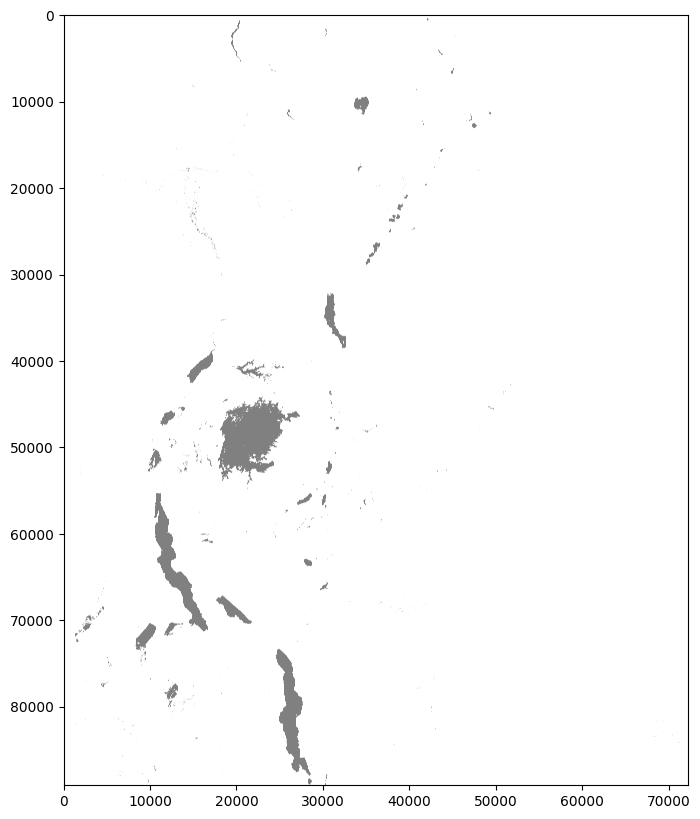

In [22]:
# Plot the rasterized data
fig, ax = plt.subplots(figsize=(10, 10)) 

plt.imshow(raster_class, cmap='gray', alpha=0.5)  # Adjust cmap and alpha as needed

# Show the plot
plt.show()

## Rasterized Plot with Axis Representing Coordinates ##

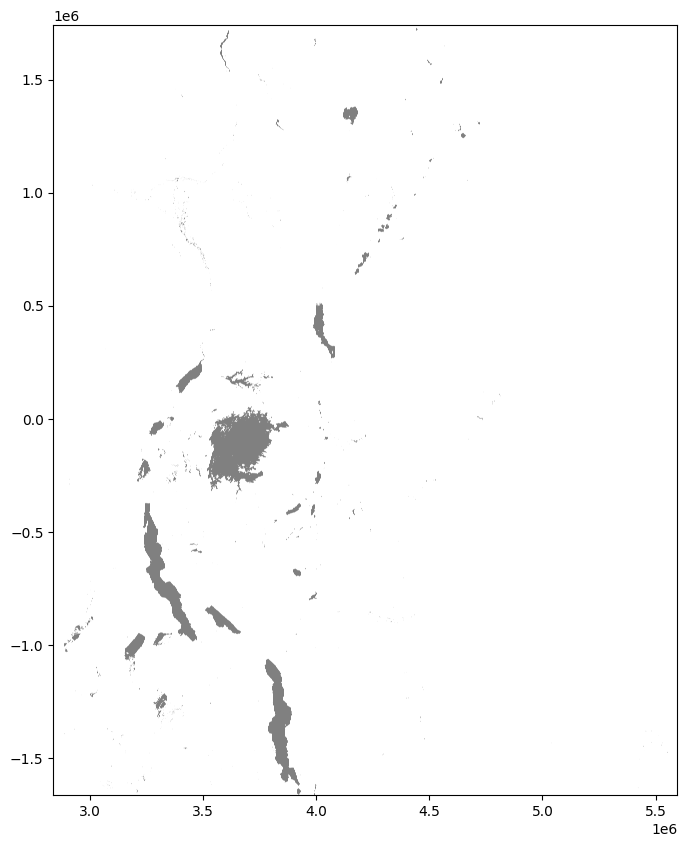

In [22]:
# Plot the rasterized data in black and white
fig, ax = plt.subplots(figsize=(10, 10)) 

plt.imshow(raster_class, extent = (new_transform[2], 
        new_transform[2] + new_transform[0]*raster_class.shape[1],
        new_transform[5] + new_transform[4]*raster_class.shape[0],
        new_transform[5]
),  cmap='gray', alpha=0.5)  

# Show the plot
plt.show()

## Rasterized Plot with Axis Representing Coordinates and Kenya Bounds ##

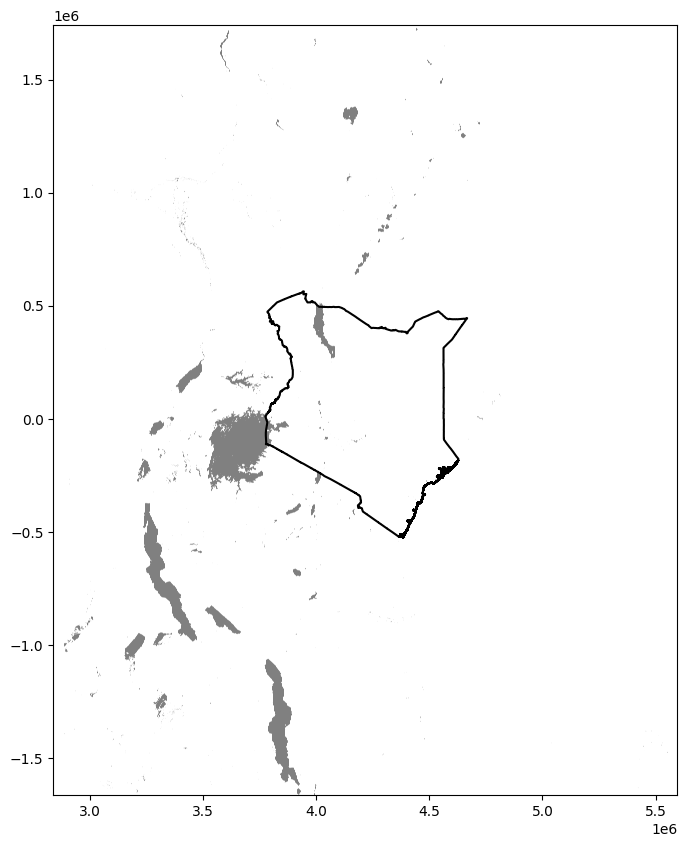

In [32]:
# Plot the rasterized data in black and white
fig, ax = plt.subplots(figsize=(10, 10)) 

plt.imshow(raster_class, extent = (new_transform[2], 
        new_transform[2] + new_transform[0]*raster_class.shape[1],
        new_transform[5] + new_transform[4]*raster_class.shape[0],
        new_transform[5]
),  cmap='gray', alpha=0.5)  # Use 'binary' colormap for black and white

# Overlay the boundary plot (kenya_admin0)
kenya_admin0.boundary.plot(ax=ax, color='k')

# Show the plot
plt.show()

## Plot the Vector Geometeries and Overlay Kenya Boundary ##

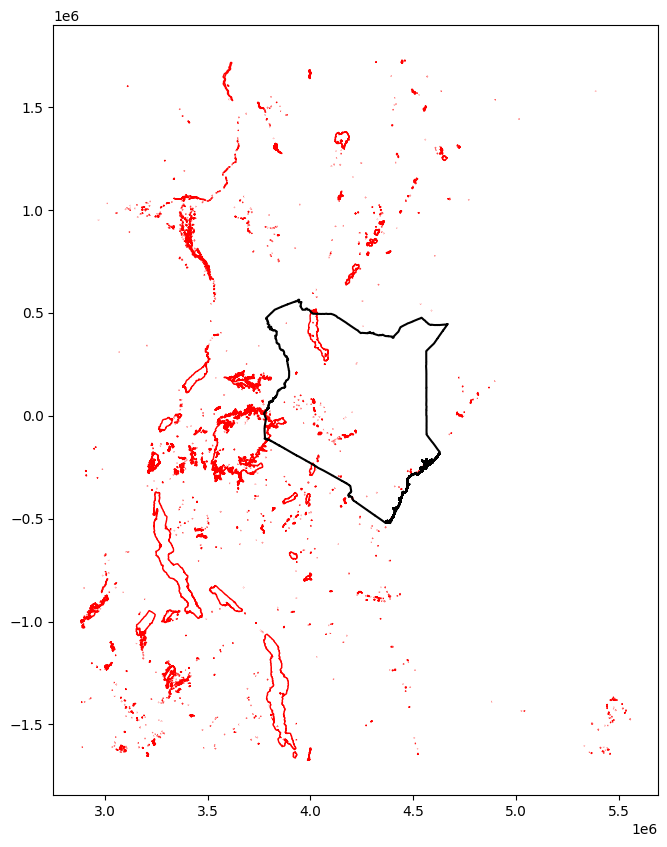

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the original vector geometries (kenya_expanded)
kenya_expanded.plot(ax=ax, edgecolor='red', facecolor='none')

# Overlay the boundary plot (kenya_admin0)
kenya_admin0.boundary.plot(ax=ax, color='k')

plt.show()


# Run Distance Computation #

In [13]:
%%time
out = distance_transform_edt(raster_class)

CPU times: user 21min 27s, sys: 5min, total: 26min 27s
Wall time: 26min 28s


In [14]:
out.shape

(89088, 72192)

In [15]:
np.save('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/hydrosheds/lakes/computed_distances.npy', out)

In [18]:
out = np.load('/mnt/share/homes/mfiking/population/gis/population/distance_covariates/hydrosheds/lakes/computed_distances.npy')

In [19]:
out.shape

(89088, 72192)

# Plot Distance Before Stamp #

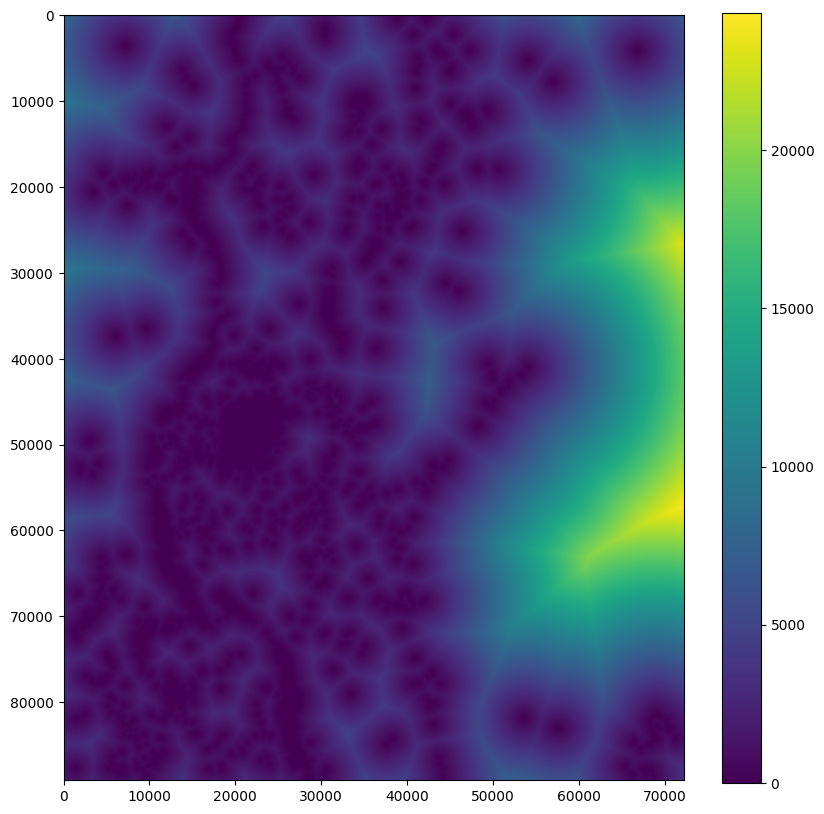

In [26]:
fig, ax = plt.subplots(figsize=(10, 10)) 
# Create a heatmap using Matplotlib
plt.imshow(out, cmap='viridis')
# Add colorbar for reference
plt.colorbar()
# Show the plot
plt.show()

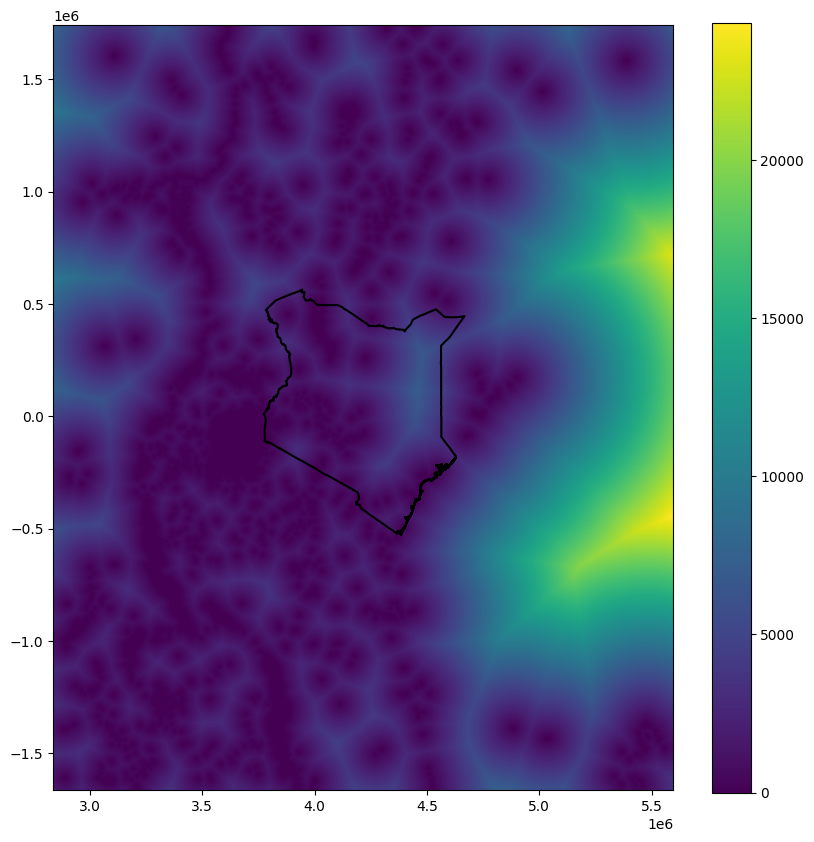

In [25]:
fig, ax = plt.subplots(figsize=(10, 10)) 

plt.imshow(out, extent = (new_transform[2], 
        new_transform[2] + new_transform[0]*raster_class.shape[1],
        new_transform[5] + new_transform[4]*raster_class.shape[0],
        new_transform[5]
),  cmap='viridis') 

# Add colorbar for reference
plt.colorbar()

# Overlay the boundary plot (kenya_admin0)
kenya_admin0.boundary.plot(ax=ax, color='k')

# Show the plot
plt.show()

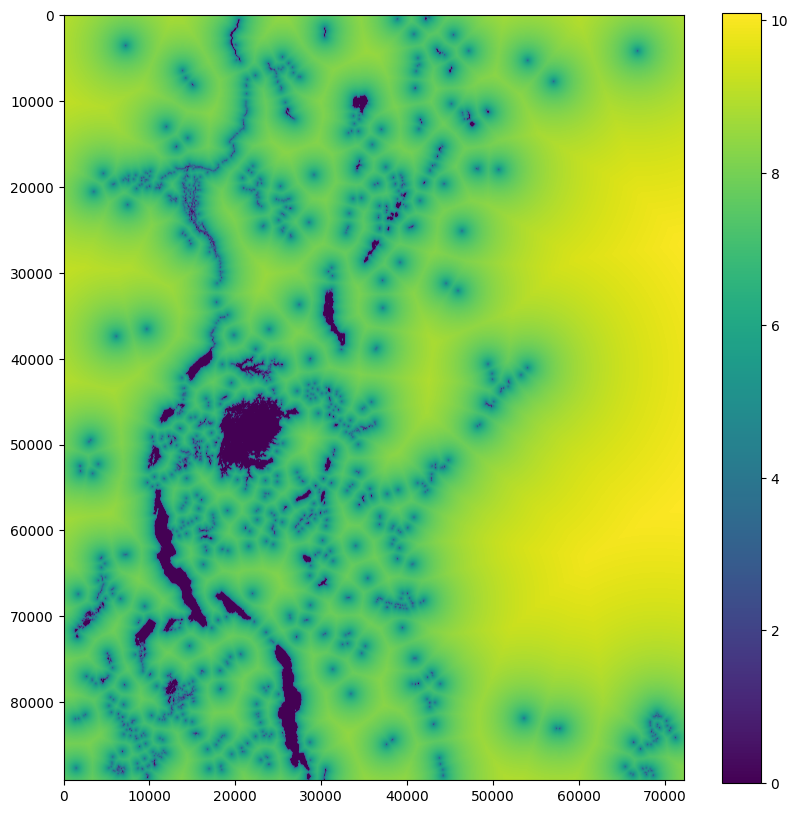

In [27]:

fig, ax = plt.subplots(figsize=(10, 10)) 

# Create a heatmap using Matplotlib
plt.imshow(np.log(1 + out), cmap='viridis')
# Add colorbar for reference
plt.colorbar()
# Show the plot
plt.show()

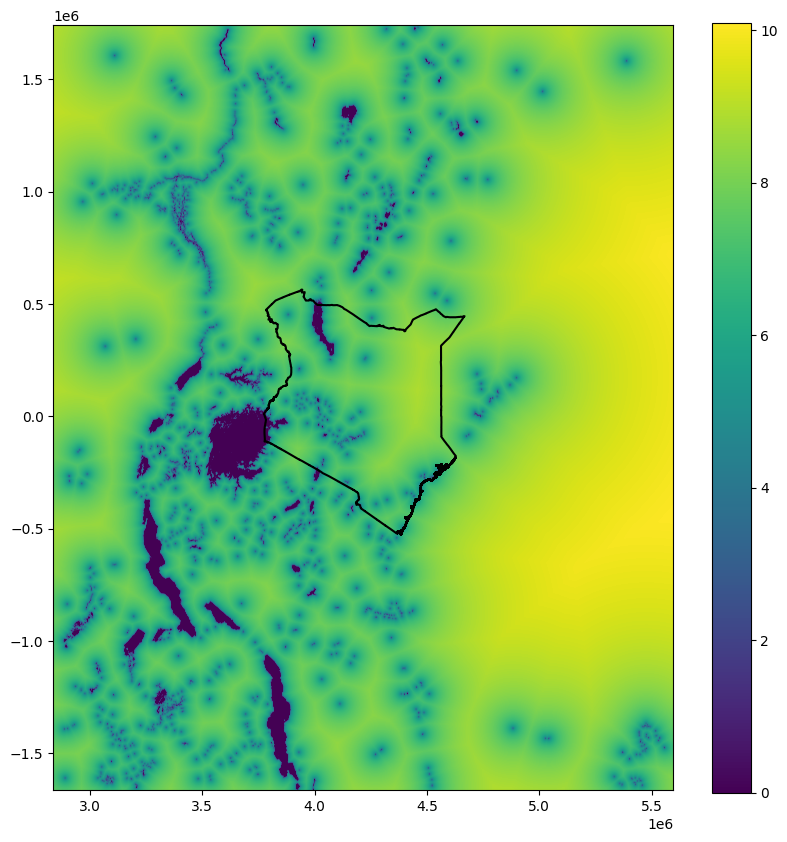

In [20]:
fig, ax = plt.subplots(figsize=(10, 10)) 

plt.imshow(np.log(1 + out), extent = (new_transform[2], 
        new_transform[2] + new_transform[0]*raster_class.shape[1],
        new_transform[5] + new_transform[4]*raster_class.shape[0],
        new_transform[5]
),  cmap='viridis') 

# Add colorbar for reference
plt.colorbar()

# Overlay the boundary plot (kenya_admin0)
kenya_admin0.boundary.plot(ax=ax, color='k')

# Show the plot
plt.show()

# Kenya Admin0 Bounded #

In [21]:
# Subset Expanded Array back to Original Array 
start_row = kenya_shape[0]
end_row = kenya_shape[0]*2
start_col = kenya_shape[1]
end_col = kenya_shape[1]*2

In [22]:
original_out = out[start_row:end_row, start_col:end_col]

In [23]:
original_out.shape

(29696, 24064)

In [24]:
kenya_shape

(29696, 24064)

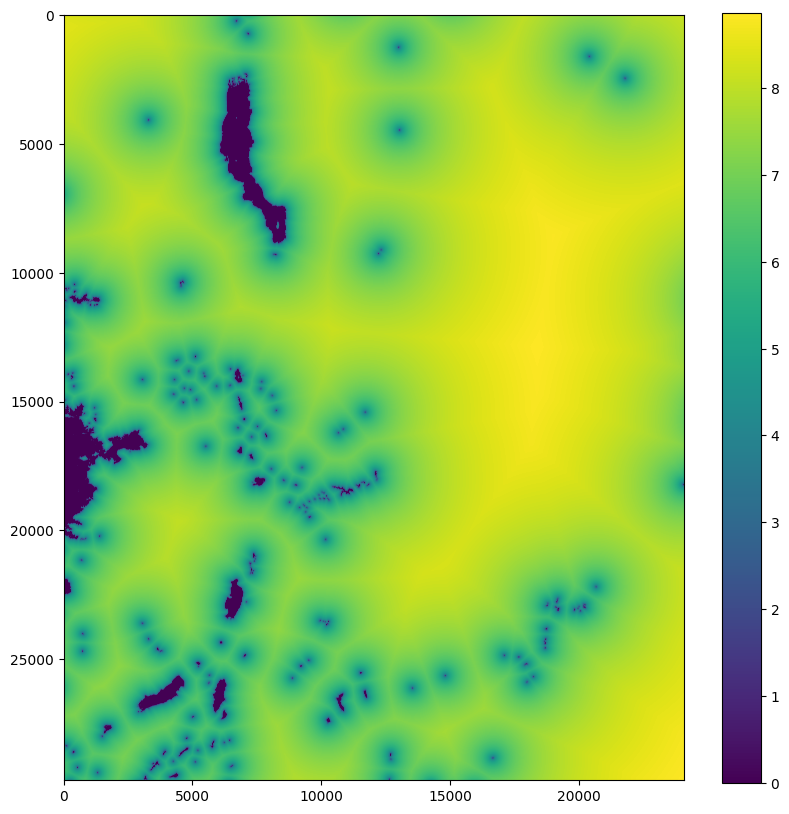

In [25]:
# Create a heatmap using Matplotlib
fig, ax = plt.subplots(figsize=(10, 10)) 

plt.imshow(np.log(1 + original_out), cmap='viridis')
# Add colorbar for reference
plt.colorbar()
# Show the plot
plt.show()

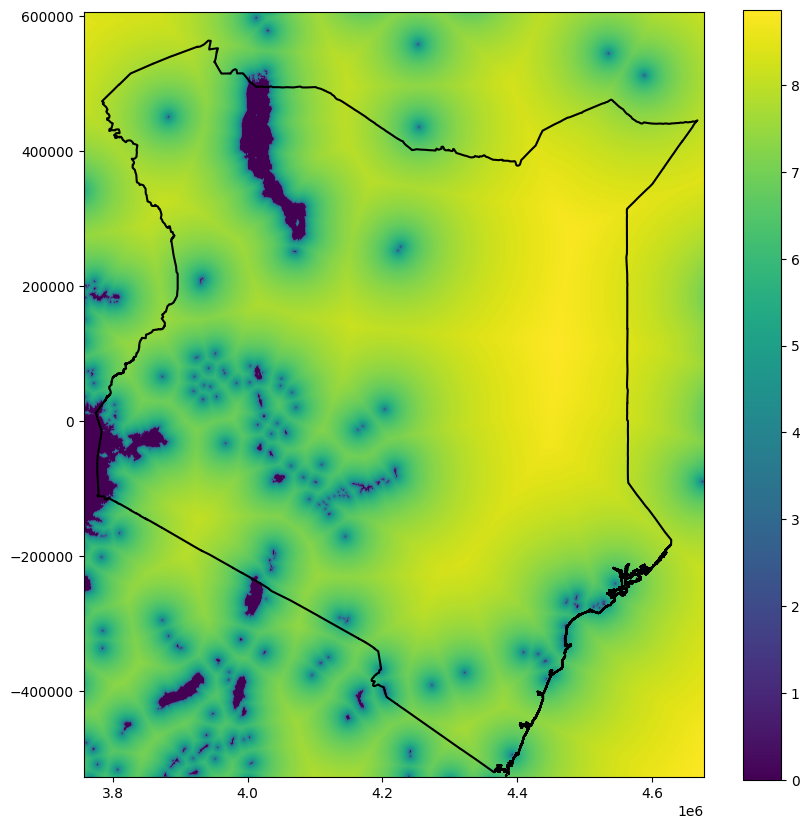

In [27]:
fig, ax = plt.subplots(figsize=(10, 10)) 

plt.imshow(np.log(1 + original_out), extent = (transform[2], 
        transform[2] + transform[0]*original_out.shape[1],
        transform[5] + transform[4]*original_out.shape[0],
        transform[5]
),  cmap='viridis') 

# Add colorbar for reference
plt.colorbar()

# Overlay the boundary plot (kenya_admin0)
kenya_admin0.boundary.plot(ax=ax, color='k')

# Show the plot
plt.show()

# Kenya Stamp #

In [33]:
# Use Natural Earth Shape file as place holder
admin0_path = Path('/mnt/team/rapidresponse/pub/population/data/01-raw-data/shapefiles/KEN/Unknown/gadm41_KEN_shp/gadm41_KEN_0.shp')


# Define paths and filenames
out_path = f'/mnt/share/homes/mfiking/population/gis/population/distance_covariates/hydrosheds/lakes/expanded/hydrolakes_kenya.tif'
plot_path = f'/mnt/share/homes/mfiking/population/gis/population/distance_covariates/hydrosheds/lakes/expanded/plots/hydrolakes.jpg'
log_plot_path = f'/mnt/share/homes/mfiking/population/gis/population/distance_covariates/hydrosheds/lakes/expanded/plots/log_hydrolakes.jpg'

In [34]:
original_out = original_out.astype(out_meta['dtype'])

# Write to raster file
with rasterio.open(out_path, "w", **out_meta) as dest:
    dest.write(original_out.reshape((1, *original_out.shape)))

# Apply mask and save plot
mask_admin(out_path, admin0_path, out_path)

In [35]:
# Read in New Raster
with rasterio.open(out_path) as src:
    combined_raster = src.read(1, masked=True)
    transform = src.transform

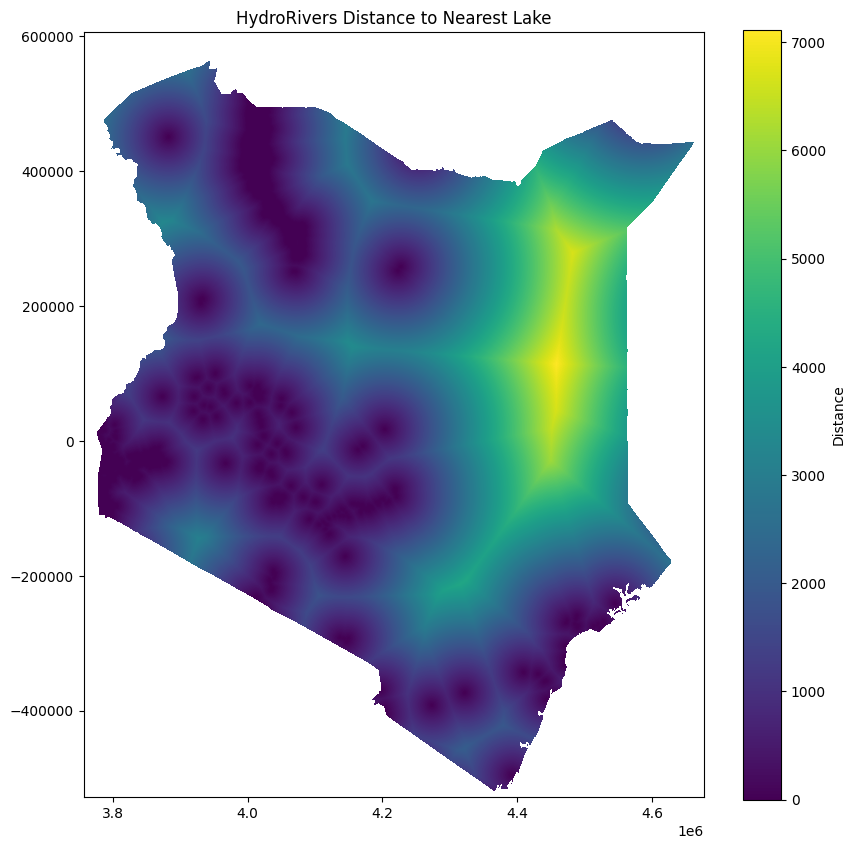

In [45]:
# Plot log transformed raster
plt.figure(figsize=(10, 10))

plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')
cb = plt.colorbar()
cb.set_label('Distance')
plt.title(f'HydroRivers Distance to Nearest Lake')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')

plt.show()

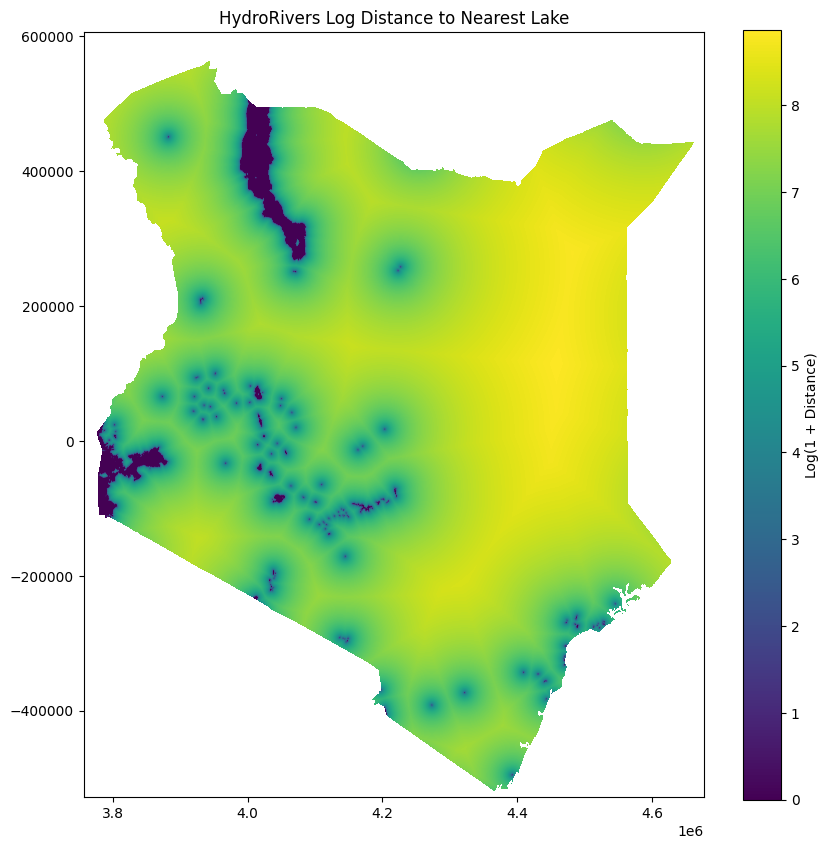

In [49]:
# Plot log transformed raster
plt.figure(figsize=(10, 10))
log_combined_raster = np.log(1 + combined_raster)

plt.imshow(log_combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')
cb = plt.colorbar()
cb.set_label('Log(1 + Distance)')
plt.title(f'HydroRivers Log Distance to Nearest Lake')
plt.savefig(log_plot_path, dpi=300, bbox_inches='tight')


plt.show()

# Test #

# Correct Plots #

<Axes: >

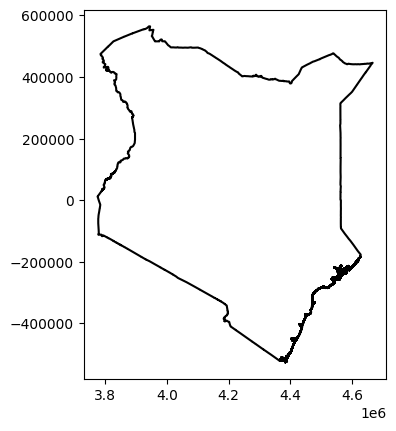

In [52]:
# Overlay the boundary plot (kenya_admin0)
kenya_admin0.boundary.plot(color='k')


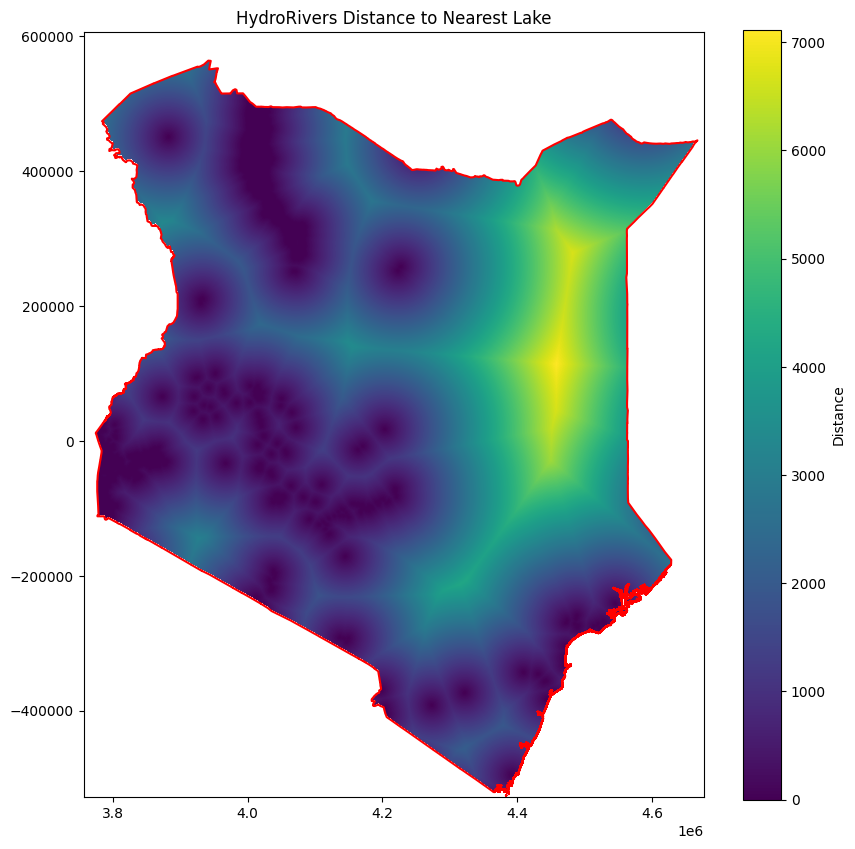

In [63]:
# Plot log transformed raster
fig, ax = plt.subplots(figsize=(10, 10)) 
plt.imshow(combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')
cb = plt.colorbar()
cb.set_label('Distance')
plt.title(f'HydroRivers Distance to Nearest Lake')
# Overlay the boundary plot (kenya_admin0)
kenya_admin0.boundary.plot(ax=ax, color='red')


plt.show()





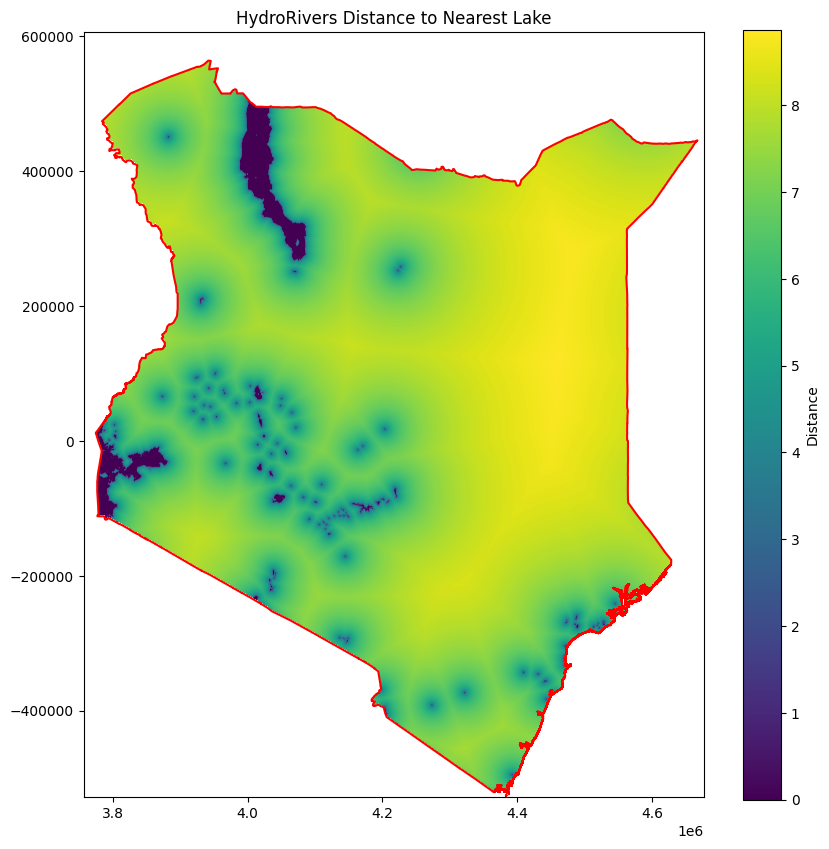

In [64]:

# Plot log transformed raster
fig, ax = plt.subplots(figsize=(10, 10)) 
plt.imshow(log_combined_raster, extent=(transform[2], transform[2] + transform[0]*combined_raster.shape[1],
                                   transform[5] + transform[4]*combined_raster.shape[0], transform[5]), cmap='viridis')
cb = plt.colorbar()
cb.set_label('Distance')
plt.title(f'HydroRivers Distance to Nearest Lake')
# Overlay the boundary plot (kenya_admin0)
kenya_admin0.boundary.plot(ax=ax, color='red')


plt.show()

